#### Algoritmo de Canny para detección de bordes
##### Realizado por Ithiel Piñero Darias
##### Asignatura: Visión por Computador

###### Cargamos librerias

In [548]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

###### Cargamos las imágenes

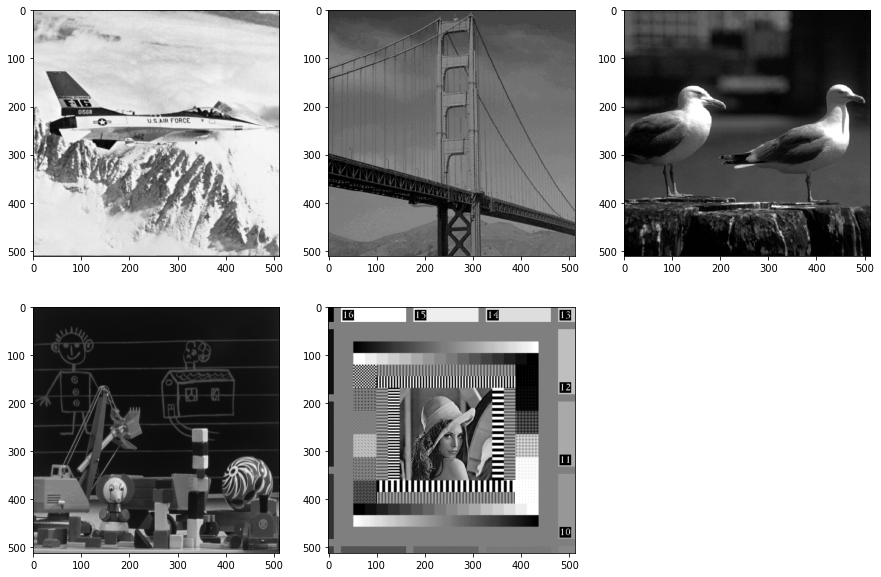

In [549]:
img = cv2.imread("10.pgm",0)
img2 = cv2.imread("25.pgm",0)
img3 = cv2.imread("27.pgm",0)
img4 = cv2.imread("65.pgm",0)
img5 = cv2.imread("92.pgm",0)

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(img,"gray")
plt.subplot(2,3,2)
plt.imshow(img2,"gray")
plt.subplot(2,3,3)
plt.imshow(img3,"gray")
plt.subplot(2,3,4)
plt.imshow(img4,"gray")
plt.subplot(2,3,5)
plt.imshow(img5,"gray")

###### Detección de fronteras

El primer paso es realizar la detección de fronteras. Realizamos un filtro guassiano de desviación estándar sobre la imagen  con un sigma dado, a partir de ahí construimos los dos filtros con los cuales extraeremos los gradientes de dirección que nos servirán para obtener la magnitud y dirección del gradiente. 

In [550]:
    def deteccionFronteras(img, sigma):
        suavizado=cv2.GaussianBlur(img,(5,5),sigma)
        
        Kx = np.array([[-0.5,0.5], [-0.5,0.5]], np.float32)
        Ky = np.array([[0.5, 0.5], [-0.5,-0.5]], np.float32)

        Gx=cv2.filter2D(suavizado,-1,Kx)
        Gy=cv2.filter2D(suavizado,-1,Ky)
        
        m = np.hypot(Gx,Gy)
        m = m.astype("uint8")
        o = np.arctan2(Gy, Gx)
        o = o.astype("uint8")
        
        return (m,o)

###### Supresión de no máximos

Nuestra labor siguiente es suprimir aquellos pixeles que no son máximos. Aquellos que sean máximos locales en con respecto a su grupo de vecinos más cercanos mantendrán su valor, sin embargo, en caso contrario recibirán el valor de 0. Según la dirección comprobaremos la magnitud correspondiente para saber si es mayor o menor que el pixel en cuestión. 

In [551]:
def supnomax(m,o):
    e = np.zeros((m.shape[0],m.shape[1]))
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if(o[i,j]==0):

                if (j-1 < 0 or j+1 == m.shape[1]):
                    if(j-1 < 0):
                        if(m[i,j] < m[i,j+1]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]
                    else:
                        if(m[i,j] < m[i,j-1]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]

                elif(m[i,j] < m[i,j-1] or m[i,j] < m[i,j+1]):
                    e[i,j] = 0
                else:
                    e[i,j] = m[i,j]
        
            elif(o[i,j]==1):
            
                if(i+1 == m.shape[0] or i-1 < 0 or j-1 < 0 or j+1 == m.shape[1]):
                    if((i+1 == m.shape[0] and j+1 == m.shape[1]) or (i-1<0 and j-1<0)):
                        e[i,j] = m[i,j]
                        
                    elif(i+1 == m.shape[0] or j-1 < 0):
                        if(m[i,j] < m[i-1,j+1]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]
                        
                    elif(j+1 == m.shape[1] or i-1 < 0):
                        if(m[i,j] < m[i+1,j-1]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]
                    else:
                        e[i,j] = m[i,j]
                    
                elif(m[i,j] < m[i+1,j-1] or m[i,j] < m[i-1,j+1]):
                    e[i,j] = 0
                else:
                    e[i,j] = m[i,j]
                
            elif(o[i,j]==2):
                if(i+1 == m.shape[0] or i-1 <0):
                    if(i+1 == img.shape[0]):
                        if(m[i,j] < m[i-1,j]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]
                    else:
                        if(m[i,j] < m[i+1,j]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]
                        
                elif(m[i,j] < m[i-1,j] or m[i,j] < m[i+1,j]):
                    e[i,j] = 0
                else:
                    e[i,j] = m[i,j]
            else:
            
                if(i-1<0 or j-1<0 or i+1 == m.shape[0] or j+1 == m.shape[1]):    
                    if(i-1<0 or j-1 <0):
                        if(m[i,j] < m[i+1,j+1]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]
                        
                    elif(i+1 == m.shape[0] or j+1 == m.shape[1]):
                        if(m[i,j] < m[i+1,j+1]):
                            e[i,j] = 0
                        else:
                            e[i,j] = m[i,j]
                    else:
                        e[i,j] = m[i,j]
                elif(m[i,j] < m[i-1,j-1] or m[i,j] < m[i+1,j+1]):
                    e[i,j] = 0
                else:
                    e[i,j] = m[i,j]
    return e 

###### Histeresis

El último proceso es la histeresis, tomando un valor de límite inferior y superior si el pixel en cuestión tiene un valor menor al límite inferior será declarado como débil. Si fuera superior al límite superior será declarado como fuerte y comprobaremos si sus vecinos son mayores del límite inferior (en cuyo caso serán declarados como fuertes). 

In [552]:
def histeresis(img, unif,usup):
    res = np.empty((img.shape[0],img.shape[1]),"str")
    img_final = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if(res[i,j] == ""):
                if(img[i,j] < unif):
                    res[i,j] = "d"
                elif(img[i,j] > usup):
                    res[i,j] = "f"
                    
                    #fila superior
                    for z in range(j-1,j+2):
                        x = i-1 
                        if(x > 0 and z > 0 and z < img.shape[1] and res[x,z]=='' and img[x,z] > unif):
                            res[x,z] = "f"
                
                    #lado derecho
                    z= j+1
                    if(z < img.shape[1]) and(res[i,z]=='' and img[i,z] > unif):
                        res[i,z] ="f"
            
                    #lado inferior
                    for z in range(j+1,j-2,-1):
                        x=i+1
                        if(x < img.shape[1] and z > 0 and z < img.shape[1] and res[x,z]=='' and img[x,z] > unif):
                            res[x,z] ="f"
            
                    #fila izquierdo
                    z=j-1
                    if(z > 0 and res[i,z]=='' and img[i,z] > unif):
                        res[i,z] = "f"
                else:
                    res[i,j] = "c"
                    
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if(res[i,j] == "f"):
                    img_final[i,j] = 255
                else:
                    img_final[i,j] = 0
    return img_final


###### Proceso de Canny

In [553]:
def cannyManual(img,sigma,unif,usup):
    m,o = deteccionFronteras(img,sigma)
    e = supnomax(m,o)
    res = histeresis(e,unif,usup)
    return res

###### Cálculo de entropía 

Extraemos sobre los puntos fuertes la varianza del entorno del mismo como medida de entropía de cara a la comparativa de distintos sigmas.

In [554]:
def varianzaPuntos(img, res, sigma):
    img=cv2.GaussianBlur(img,(5,5),sigma)
    varianza = []
    vecindario = np.zeros((3,3))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if(res[i,j] > 0):    
                posy=0
                vecindario[1,1] = img[i,j]
                
                #fila superior
                for z in range(j-1,j+2):
                    x = i-1 
                    if(x < 0 or z < 0 or z == img.shape[1]):
                        if(x < 0):
                            x = 511
                        if(z < 0):
                            z = 511
                        if(z == img.shape[1]):
                            z=0
                    vecindario[0,posy] = img[x,z]
                    posy = posy+1
            
                #lado derecho
                z= j+1
                if(z == img.shape[1]):
                    z = 0
                vecindario[1,2] = img[i,z]
            
                #lado inferior
                posy = 0
                for z in range(j+1,j-2,-1):
                    x=i+1
                    if(x == img.shape[0] or z < 0 or z == img.shape[1]):
                        if(x == img.shape[0]):
                            x =0
                        if(z < 0):
                            z = 511
                        if(z == img.shape[1]):
                            z = 0
                        
                    vecindario[2,posy]=img[x,z]
                    posy=posy+1
            
                #fila izquierdo
                z=j-1
                if(z < 0):
                    z = 511
                vecindario[1,0] = img[i,z] 
                
                varianza.append(np.var(vecindario))
    return sum(varianza)

Text(0.5, 1.0, 'Canny')

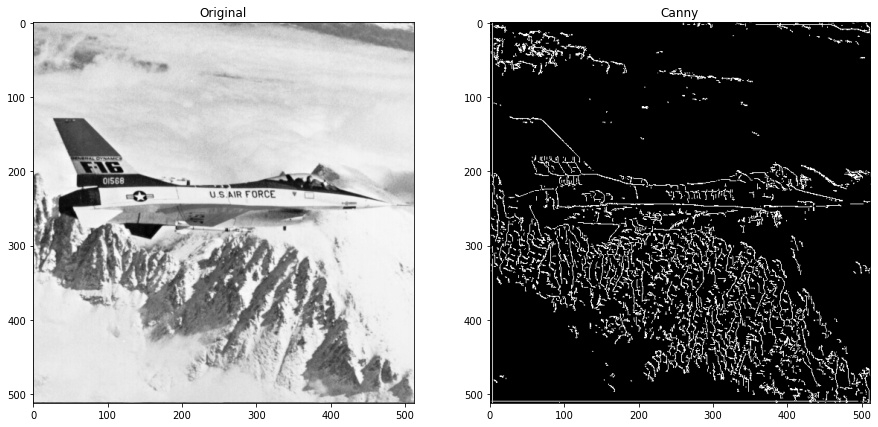

In [555]:
column_names = ["Sigma", "Puntos frontera", "Entropia"]
compAvion = pd.DataFrame(columns = column_names)
sigmas = [0.4,0.8,1.1,1.5,1.9,2.2,2.4]
for i in sigmas:
    res = cannyManual(img,i,1,2)
    entropia = varianzaPuntos(img, res, i)
    compAvion = compAvion.append({'Sigma' : i,
                    'Puntos frontera' : np.count_nonzero(res == 255),
                    'Entropia': entropia} , 
                    ignore_index=True)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img,"gray")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(res,"gray")
plt.title("Canny")

###### Avión

Podemos apreciar como a medida que aumentamos el sigma se reducen los puntos fronteras y disminuye la entropía con lo cual mejora la detección de bordes.

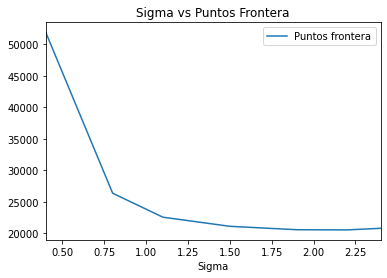

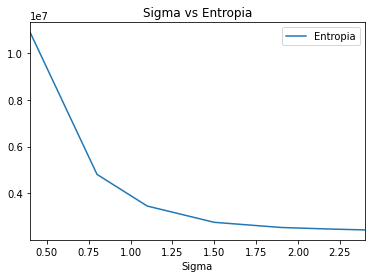

In [556]:
compAvion.plot(x="Sigma", y="Puntos frontera", title="Sigma vs Puntos Frontera")
compAvion.plot(x="Sigma", y="Entropia", title = "Sigma vs Entropia")

Text(0.5, 1.0, 'Canny')

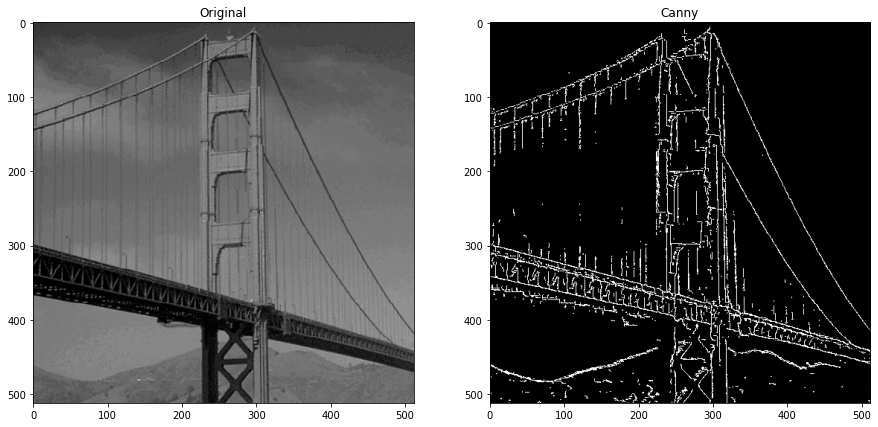

In [561]:
compPuente = pd.DataFrame(columns = column_names)
sigmas = [0.4,0.8,1.1,1.5,1.9,2.2,2.4]
for i in sigmas:
    res = cannyManual(img2,i,1,2)
    entropia = varianzaPuntos(img2, res, i)
    compPuente = compPuente.append({'Sigma' : i,
                    'Puntos frontera' : np.count_nonzero(res == 255),
                    'Entropia': entropia} , 
                    ignore_index=True)
    
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img2,"gray")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(res,"gray")
plt.title("Canny")

###### Puente

Podemos apreciar de nuevo como aumentando el sigma obtenemos menos puntos fronteras y, a su vez, es menor la entropía con lo cual podemos pensar que los puntos fronteras que existen son más precisos. 

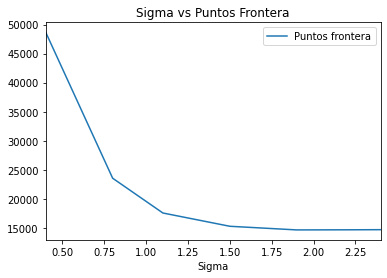

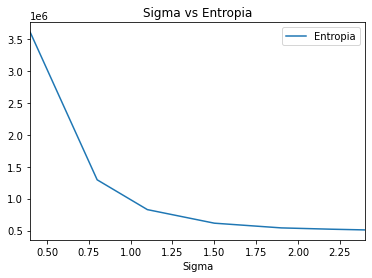

In [562]:
compPuente.plot(x="Sigma", y="Puntos frontera", title="Sigma vs Puntos Frontera")
compPuente.plot(x="Sigma", y="Entropia", title = "Sigma vs Entropia")

###### Pájaros

Al igual que en los dos casos previos, al aumentar el valor de sigma parece descender el número de puntos frontera y la entropía con la salvedad de que en esta ocasión se produce un mínimo de puntos frontera a un sigma de 1.50 y a partir de ahí aumentan ligeramente.

Text(0.5, 1.0, 'Canny')

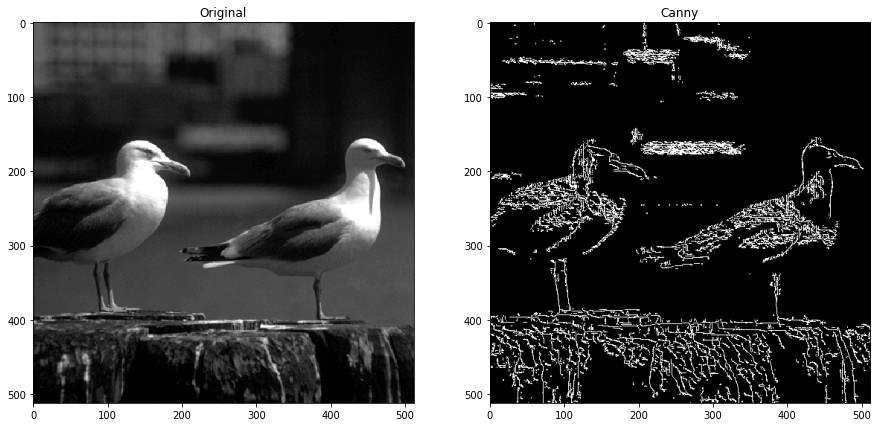

In [565]:
compPajaros = pd.DataFrame(columns = column_names)
sigmas = [0.4,0.8,1.1,1.5,1.9,2.2,2.4]
for i in sigmas:
    res = cannyManual(img3,i,1,2)
    entropia = varianzaPuntos(img3, res, i)
    compPajaros = compPajaros.append({'Sigma' : i,
                    'Puntos frontera' : np.count_nonzero(res == 255),
                    'Entropia': entropia} , 
                    ignore_index=True)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img3,"gray")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(res,"gray")
plt.title("Canny")

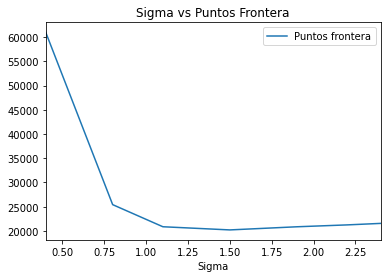

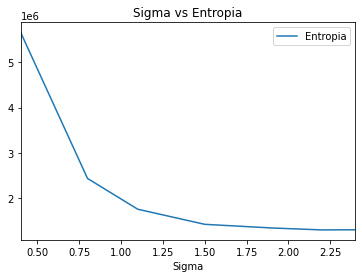

In [566]:
compPajaros.plot(x="Sigma", y="Puntos frontera", title="Sigma vs Puntos Frontera")
compPajaros.plot(x="Sigma", y="Entropia", title = "Sigma vs Entropia")

Text(0.5, 1.0, 'Canny')

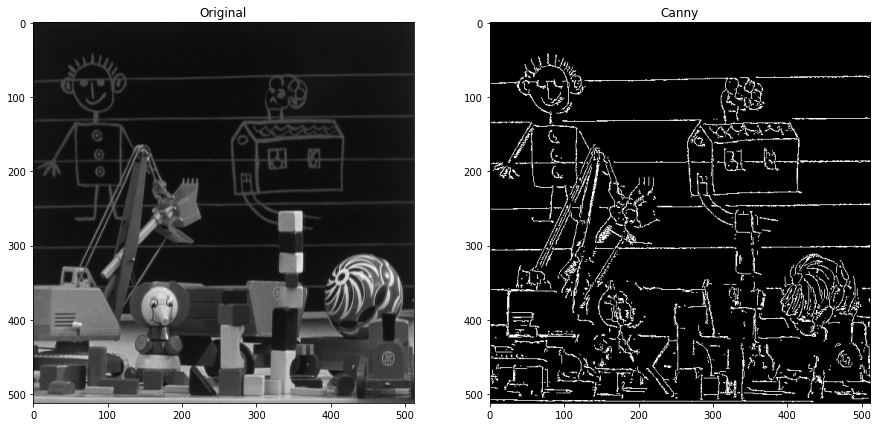

In [567]:
compJuguetes = pd.DataFrame(columns = column_names)
sigmas = [0.4,0.8,1.1,1.5,1.9,2.2,2.4]
for i in sigmas:
    res = cannyManual(img4,i,1,2)
    entropia = varianzaPuntos(img4, res, i)
    compJuguetes = compJuguetes.append({'Sigma' : i,
                    'Puntos frontera' : np.count_nonzero(res == 255),
                    'Entropia': entropia} , 
                    ignore_index=True)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img4,"gray")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(res,"gray")
plt.title("Canny")

###### Juguetes

Similar al caso anterior de pájaros, desciende el nº de puntos fronteras al aumentar el sigma hasta que llegamos al valor de 1.05-1.15 que parece producir un mínimo, a partir de ahí aumenta ligeramente el nº de puntos frontera. Por su parte la entropía parece descender ligeramente a partir de ese mismo valor de sigma hasta formar al final casi una asíntota. 

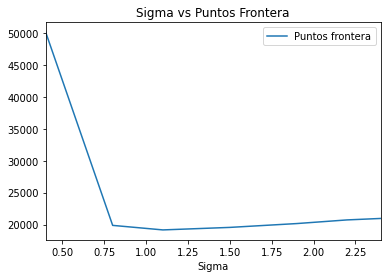

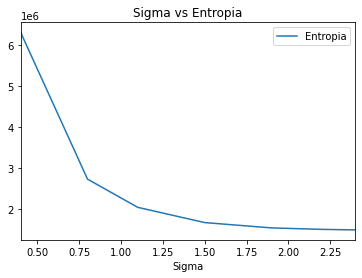

In [568]:
compJuguetes.plot(x="Sigma", y="Puntos frontera", title="Sigma vs Puntos Frontera")
compJuguetes.plot(x="Sigma", y="Entropia", title = "Sigma vs Entropia")

Text(0.5, 1.0, 'Canny')

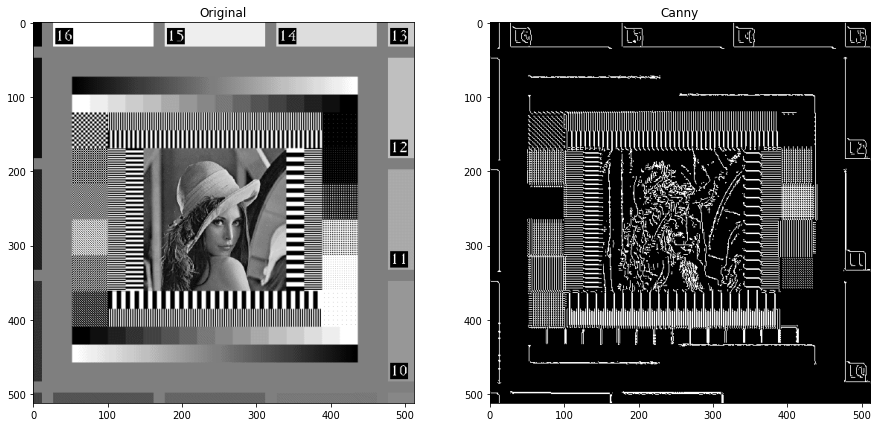

In [569]:
compPersona = pd.DataFrame(columns = column_names)
sigmas = [0.4,0.8,1.1,1.5,1.9,2.2,2.4]
for i in sigmas:
    res = cannyManual(img5,i,1,2)
    entropia = varianzaPuntos(img5, res, i)
    compPersona = compPersona.append({'Sigma' : i,
                    'Puntos frontera' : np.count_nonzero(res == 255),
                    'Entropia': entropia} , 
                    ignore_index=True)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img5,"gray")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(res,"gray")
plt.title("Canny")

###### Persona

En esta ocasión, el valor mínimo de puntos fronteras en relación al sigma es 1.50, a partir de ahí comienzan a crecer notablemente los puntos frontera. Por su parte, la entropía desciende hasta un sigma de 1.25 a partir del cual parece seguir una relación asintótica. 

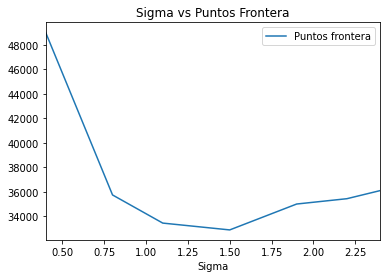

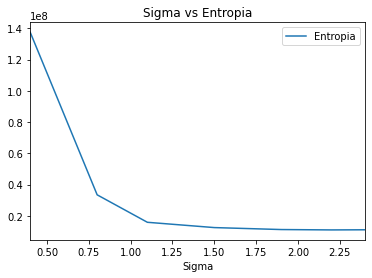

In [570]:
compPersona.plot(x="Sigma", y="Puntos frontera", title="Sigma vs Puntos Frontera")
compPersona.plot(x="Sigma", y="Entropia", title = "Sigma vs Entropia")